In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pickle as pkl
import nn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('Set2', 10)
sns.set_style('whitegrid')

## Загрузим данные, поделим выборку на тренировочную, валидационную и тестовую.

In [13]:
from sklearn.utils import shuffle
with open('mnist/data.pkl', 'rb') as f:
	data = pkl.load(f)
X_raw = (data['X'] - 128.) / 128.
y_raw = data['y']

from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X_raw, y_raw, test_size = .2, random_state = 42)		#20% of data = leave for test
#X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size = .25, random_state = 42) 	#20% of data = leave for validation
print (X_train.shape, y_train.shape)
#print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

from sklearn.metrics import accuracy_score

NEPOCH = 30
NITER = 4200
BSIZE = X_train.shape[0] // NITER

results_all = []

(56000, 784) (56000, 10)
(14000, 784) (14000, 10)


## Напишем 2 функции:
* для обучения нейросети с передачей параметров обучения 
* для построения графиков обучения

In [19]:
def main(model, X_train, y_train, X_test, y_test, 
         n_epoch=NEPOCH, n_iter=NITER, 
         learning_rate=1e-03, learning_rate_evolution=None,
         lambda_reg = 0.,
         layers_to_check_gradients = []):

    batch_size = X_train.shape[0] // n_iter
    learning_rate_initial = learning_rate
    
    evaluation_results = {'accuracy_train' : [],
                          'accuracy_test' : [],
                          'loss_train' : []}
    
    loss = model.forward(inputs=X_train, target=y_train, return_loss=True) / n_iter
    evaluation_results['loss_train'].append(loss)

    predictions_train = model.forward(inputs=X_train, target=y_train, return_loss=False)
    accuracy_train = accuracy_score((predictions_train == np.amax(predictions_train, axis=1).reshape((-1, 1))).astype(int), y_train)
    evaluation_results['accuracy_train'].append(accuracy_train)

    predictions_test = model.forward(inputs=X_test, target=y_test, return_loss=False)
    accuracy_test = accuracy_score((predictions_test == np.amax(predictions_test, axis=1).reshape((-1, 1))).astype(int), y_test)
    evaluation_results['accuracy_test'].append(accuracy_test)
        
    print ('Epoch: %-5dLoss: %-10.5fAccuracy (train): %-10.5fAccuracy (test): %-10.5f' % (0, loss, accuracy_train, accuracy_test))

    for epoch in xrange(1, n_epoch + 1):
        X, y = shuffle(X_train, y_train)
        avg_loss = 0
        
        if learning_rate_evolution == 'decay':
            learning_rate = learning_rate_initial / np.sqrt(epoch + 1)
        elif learning_rate_evolution == 'discrete':
            if epoch == n_epoch // 2 or epoch == 3 * n_epoch // 4:
                learning_rate /= 2

        for it in xrange(n_iter):
            inputs = X[it:it+batch_size,:]
            target = y[it:it+batch_size,:]
            loss = model.forward(inputs=inputs, target=target)
            avg_loss += loss
            model.backward(learning_rate=learning_rate, lambda_reg=lambda_reg)

        avg_loss /= NITER
        evaluation_results['loss_train'].append(avg_loss)
        
        gcheck = []
        for layer in layers_to_check_gradients:
            gcheck.append(model.gradient_check(layer, inputs, target)[-1])
        gcheck = [round(j, 5) for j in gcheck]
        
        predictions_train = model.forward(inputs=X_train, target=y_train, return_loss=False)
        accuracy_train = accuracy_score((predictions_train == np.amax(predictions_train, axis=1).reshape((-1, 1))).astype(int), y_train)
        evaluation_results['accuracy_train'].append(accuracy_train)
        
        predictions_test = model.forward(inputs=X_test, target=y_test, return_loss=False)
        accuracy_test = accuracy_score((predictions_test == np.amax(predictions_test, axis=1).reshape((-1, 1))).astype(int), y_test)
        evaluation_results['accuracy_test'].append(accuracy_test)
        
        print ('Epoch: %-5dLoss: %-10.5fAccuracy (train): %-10.5fAccuracy (test): %-10.5f' % (epoch, avg_loss, accuracy_train, accuracy_test))
        if layers_to_check_gradients != []:
            print ('Gradients averaged differences for selected layers:', *gcheck)
    #predictions_test = model.forward(inputs=X_test, target=y_test, return_loss=False)
    #accuracy_test = accuracy_score((predictions_test == np.amax(predictions_test, axis=1).reshape((-1, 1))).astype(int), y_test)
    print ('Final accuracy on test_set: %-10.5f' % accuracy_test)  

    return evaluation_results

In [17]:
def plot_results(results, caption):

    plt.figure(figsize=(16, 6))
    plt.suptitle(caption, fontsize=20)
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(results['loss_train'])), results['loss_train'], label = 'loss_train')
    plt.xlabel('# of epoch')
    plt.ylabel('loss')
    plt.legend(fontsize=15, loc='best')
    
    for x, y in results.items():
        plt.subplot(1, 2, 2)
        if x == 'loss_train':
            continue
        plt.plot(range(len(y)), y, label=x)
        plt.xlabel('# of epoch')
        plt.ylabel('accuracy')
        
    plt.legend(fontsize=15, loc='best')
    
    plt.show()

# 0. Проверим написанные градиенты

#### Сгенерируем тестовые данные

In [5]:
sz = (100, 100)
X = np.random.normal(loc = 10., scale = 1., size = sz)
y = np.zeros(shape=sz)
mask = np.random.randint(0, 10, size=(sz[0], 1))
for j in xrange(sz[0]):
    y[j, mask[j]] = 1
print (y)

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]]


In [6]:
to_check = [nn.Log(*sz),
            nn.Sigmoid(*sz),
            nn.ReLU(*sz),
            nn.Tanh(*sz),
            nn.Logsoftmax(*sz),
            nn.NLL(),
            nn.MSE(),
            nn.CrossEntropyCriterion(),
            ]

#### Метод *local_gradient* считает и сравнивает по норме градиенты выхода слоя по входу.

In [9]:
for layer in to_check:
    print (layer.name)
    layer.local_gradient(X, y)

Log
||Grad_input_num - Grad_input_an|| / Size = 0.000000
Sigmoid
||Grad_input_num - Grad_input_an|| / Size = 0.000000
ReLU
||Grad_input_num - Grad_input_an|| / Size = 0.000000
Tanh
||Grad_input_num - Grad_input_an|| / Size = 0.000000
Logsoftmax
||Grad_input_num - Grad_input_an|| / Size = 0.009950
NLL
||Grad_input_num - Grad_input_an|| / Size = 0.000000
MSE
||Grad_input_num - Grad_input_an|| / Size = 0.000000
CrossEntropyCriterion
||Grad_input_num - Grad_input_an|| / Size = 0.000273


#### Градиенты функции потерь по параметрам линейного слоя проверяются дальше по ходу ноутбука во время обучения сети.

# 1. Логистическая регрессия

### Составим сеть для логистической регрессии с такими слоями:
1. Linear (784, 10)
2. Cross-Entropy ( )

### Обучим при фиксированном размере батча (10) и различными вариантами эволюции *learning_rate*

#### *Learning_rate* = $const$:

In [22]:
model = nn.Sequential()
model.add(nn.Linear(784, 10))
model.add(nn.CrossEntropyCriterion())
evaluation_results = main(model, X_train, y_train, X_test, y_test, X_val, y_val, learning_rate_evolution=None)
results_all.append((model, evaluation_results))

Epoch: 0    Loss: 27.01562  Accuracy (train): 0.08186   Accuracy (val): 0.07886   
Epoch: 1    Loss: 2.67804   Accuracy (train): 0.81814   Accuracy (val): 0.81514   
Epoch: 2    Loss: 1.82107   Accuracy (train): 0.85155   Accuracy (val): 0.84343   
Epoch: 3    Loss: 1.83784   Accuracy (train): 0.85540   Accuracy (val): 0.85271   
Epoch: 4    Loss: 1.77881   Accuracy (train): 0.87538   Accuracy (val): 0.86764   
Epoch: 5    Loss: 1.54576   Accuracy (train): 0.88071   Accuracy (val): 0.87407   
Epoch: 6    Loss: 1.80318   Accuracy (train): 0.90124   Accuracy (val): 0.89407   
Epoch: 7    Loss: 1.74689   Accuracy (train): 0.90188   Accuracy (val): 0.89400   
Epoch: 8    Loss: 1.52663   Accuracy (train): 0.90276   Accuracy (val): 0.89493   
Epoch: 9    Loss: 1.59348   Accuracy (train): 0.89167   Accuracy (val): 0.88379   
Epoch: 10   Loss: 1.58023   Accuracy (train): 0.89940   Accuracy (val): 0.89050   
Epoch: 11   Loss: 1.53445   Accuracy (train): 0.88998   Accuracy (val): 0.87836   
Epoc

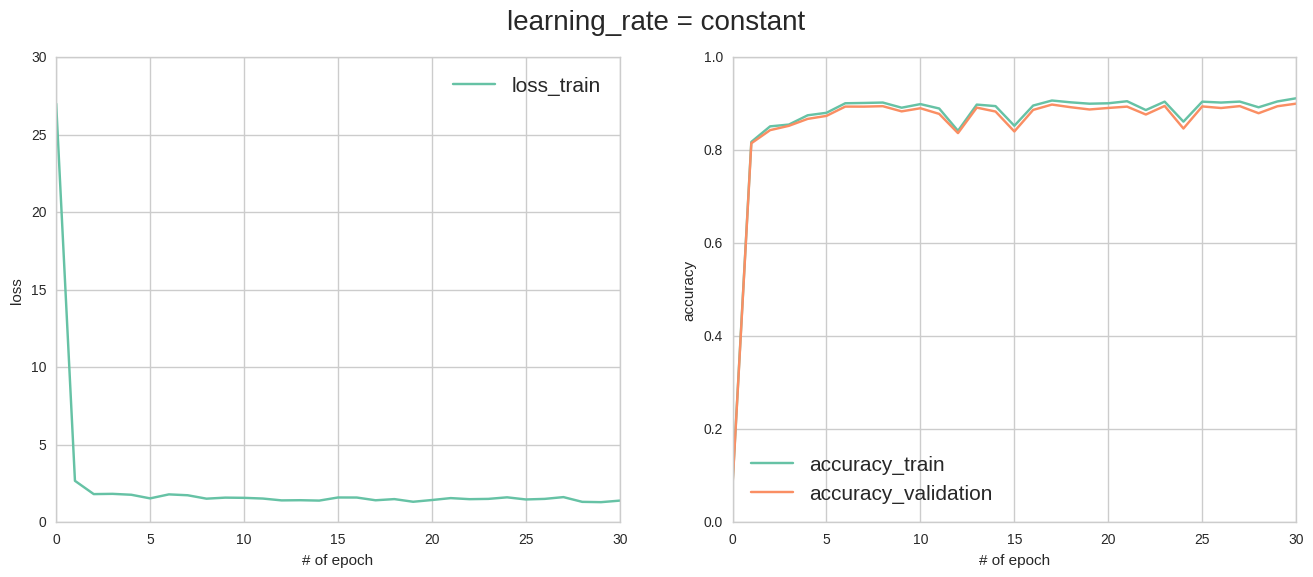

In [23]:
plot_results(evaluation_results, 'learning_rate = constant')

#### *Learning_rate* ~ $\frac{1}{\sqrt{epoch}}$:

In [24]:
model = nn.Sequential()
model.add(nn.Linear(784, 10))
model.add(nn.CrossEntropyCriterion())
evaluation_results = main(model, X_train, y_train, X_test, y_test, X_val, y_val, learning_rate_evolution='decay')

Epoch: 0    Loss: 25.07489  Accuracy (train): 0.11448   Accuracy (val): 0.11200   
Epoch: 1    Loss: 3.15067   Accuracy (train): 0.84050   Accuracy (val): 0.83700   
Epoch: 2    Loss: 2.40186   Accuracy (train): 0.86567   Accuracy (val): 0.85993   
Epoch: 3    Loss: 2.50161   Accuracy (train): 0.88450   Accuracy (val): 0.87993   
Epoch: 4    Loss: 2.23615   Accuracy (train): 0.88581   Accuracy (val): 0.87829   
Epoch: 5    Loss: 2.11550   Accuracy (train): 0.89114   Accuracy (val): 0.88493   
Epoch: 6    Loss: 2.35350   Accuracy (train): 0.87712   Accuracy (val): 0.87271   
Epoch: 7    Loss: 2.36899   Accuracy (train): 0.89143   Accuracy (val): 0.88429   
Epoch: 8    Loss: 2.14451   Accuracy (train): 0.90729   Accuracy (val): 0.89964   
Epoch: 9    Loss: 2.12977   Accuracy (train): 0.86460   Accuracy (val): 0.85321   
Epoch: 10   Loss: 2.29914   Accuracy (train): 0.90638   Accuracy (val): 0.90179   
Epoch: 11   Loss: 2.39006   Accuracy (train): 0.91376   Accuracy (val): 0.90493   
Epoc

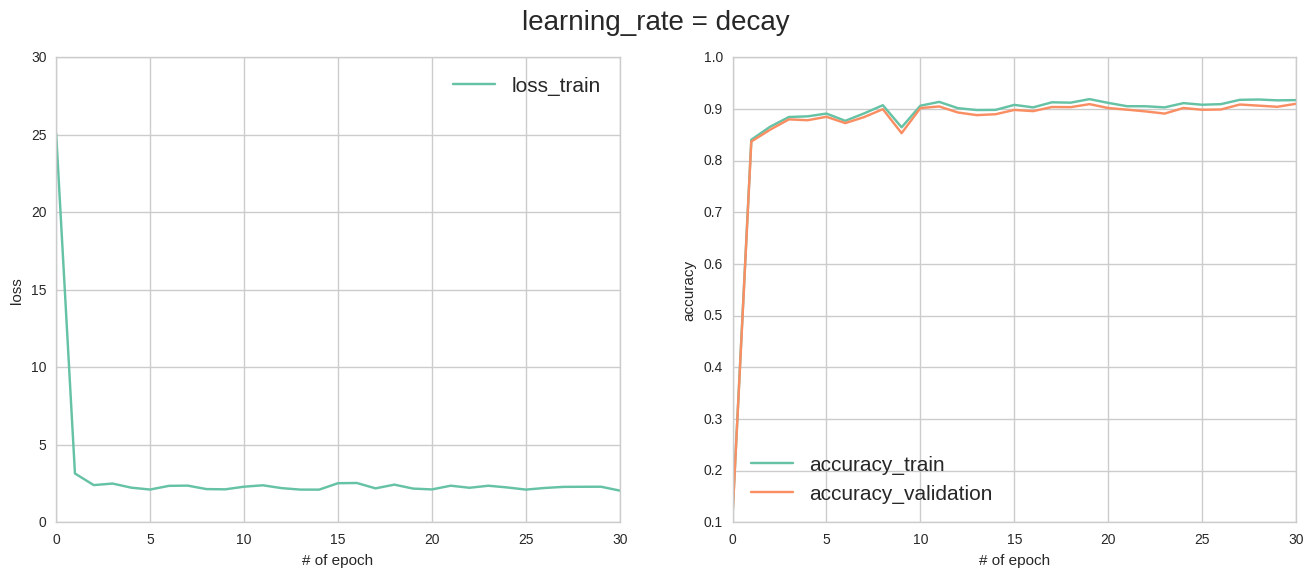

In [25]:
plot_results(evaluation_results, 'learning_rate = decay')

#### *Learning_rate* уменьшается вдвое на половине и последней четверти от числа эпох:

In [26]:
model = nn.Sequential()
model.add(nn.Linear(784, 10))
model.add(nn.CrossEntropyCriterion())
evaluation_results = main(model, X_train, y_train, X_test, y_test, X_val, y_val, learning_rate_evolution='discrete')

Epoch: 0    Loss: 26.64143  Accuracy (train): 0.08610   Accuracy (val): 0.08536   
Epoch: 1    Loss: 2.62446   Accuracy (train): 0.83679   Accuracy (val): 0.82714   
Epoch: 2    Loss: 1.80685   Accuracy (train): 0.81571   Accuracy (val): 0.80986   
Epoch: 3    Loss: 1.72667   Accuracy (train): 0.88105   Accuracy (val): 0.87564   
Epoch: 4    Loss: 1.68017   Accuracy (train): 0.86267   Accuracy (val): 0.85693   
Epoch: 5    Loss: 1.71230   Accuracy (train): 0.87369   Accuracy (val): 0.86314   
Epoch: 6    Loss: 1.51354   Accuracy (train): 0.90455   Accuracy (val): 0.89879   
Epoch: 7    Loss: 1.59321   Accuracy (train): 0.89395   Accuracy (val): 0.88950   
Epoch: 8    Loss: 1.64139   Accuracy (train): 0.86145   Accuracy (val): 0.85721   
Epoch: 9    Loss: 1.72486   Accuracy (train): 0.87381   Accuracy (val): 0.86271   
Epoch: 10   Loss: 1.57622   Accuracy (train): 0.90662   Accuracy (val): 0.89671   
Epoch: 11   Loss: 1.44603   Accuracy (train): 0.87748   Accuracy (val): 0.87229   
Epoc

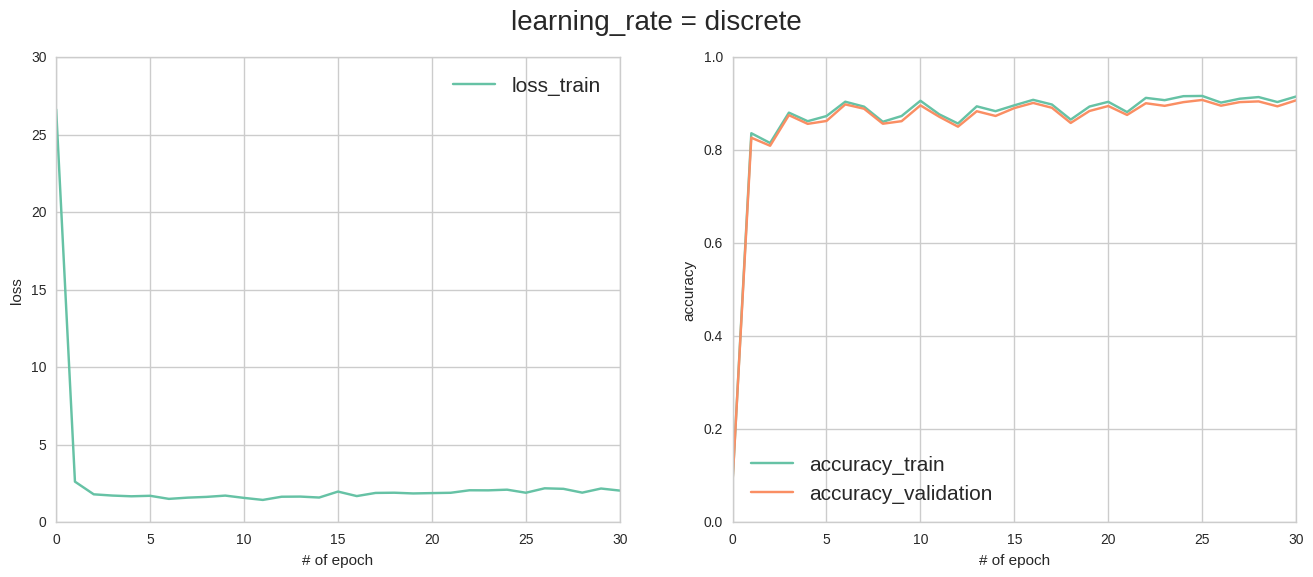

In [27]:
plot_results(evaluation_results, 'learning_rate = discrete')

### Получаем точность на тесте порядка 91%.

# 2. MLP

### Составим сеть:
1. Linear (784, 50)
2. Sigmoid (50, 50)
3. Linear (50, 10)
4. Cross-Entropy ( )

In [28]:
model2 = nn.Sequential()
model2.add(nn.Linear(784, 50), 'Linear1')
model2.add(nn.Sigmoid(50, 50))
model2.add(nn.Linear(50, 10), 'Linear2')
model2.add(nn.CrossEntropyCriterion())
evaluation_results = main(model2, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution=None, 
                          n_epoch=10, layers_to_check_gradients = ['Linear1', 'Linear2'])

Epoch: 0    Loss: 25.17158  Accuracy (train): 0.09814   Accuracy (val): 0.09521   
Epoch: 1    Loss: 8.03334   Accuracy (train): 0.84564   Accuracy (val): 0.83750   
Gradients averaged differences for selected layers: 3e-05 0.00072
Epoch: 2    Loss: 3.29463   Accuracy (train): 0.88269   Accuracy (val): 0.87729   
Gradients averaged differences for selected layers: 5e-05 0.00093
Epoch: 3    Loss: 2.59040   Accuracy (train): 0.90500   Accuracy (val): 0.89700   
Gradients averaged differences for selected layers: 1e-05 0.00018
Epoch: 4    Loss: 2.30174   Accuracy (train): 0.89290   Accuracy (val): 0.88386   
Gradients averaged differences for selected layers: 2e-05 0.00048
Epoch: 5    Loss: 2.07438   Accuracy (train): 0.91219   Accuracy (val): 0.90614   
Gradients averaged differences for selected layers: 3e-05 0.00055
Epoch: 6    Loss: 1.92664   Accuracy (train): 0.91117   Accuracy (val): 0.90614   
Gradients averaged differences for selected layers: 4e-05 0.00062
Epoch: 7    Loss: 1.816

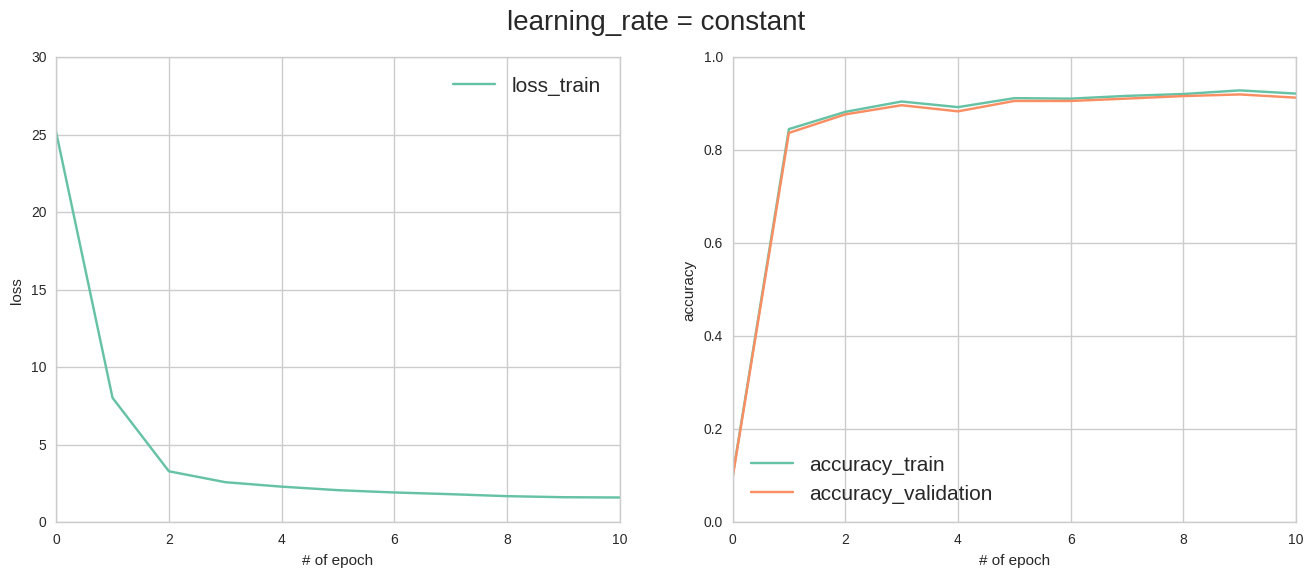

In [29]:
plot_results(evaluation_results, 'learning_rate = constant')

### Проверка градиентов на больших слоях занимает очень много времени. Т.к. мы убедились, что написанные градиенты от численных отличаются слабо, дальше будем обучаться без дополнительной проверки.

### Вновь сравним разные варианты эволюции *learning_rate*.

Epoch: 0    Loss: 23.73595  Accuracy (train): 0.11448   Accuracy (val): 0.10679   
Epoch: 1    Loss: 9.43161   Accuracy (train): 0.85371   Accuracy (val): 0.85071   
Epoch: 2    Loss: 4.34435   Accuracy (train): 0.86426   Accuracy (val): 0.86464   
Epoch: 3    Loss: 3.55795   Accuracy (train): 0.88498   Accuracy (val): 0.88436   
Epoch: 4    Loss: 3.11638   Accuracy (train): 0.89833   Accuracy (val): 0.89257   
Epoch: 5    Loss: 2.88141   Accuracy (train): 0.90590   Accuracy (val): 0.89893   
Epoch: 6    Loss: 2.74216   Accuracy (train): 0.90995   Accuracy (val): 0.90157   
Epoch: 7    Loss: 2.72395   Accuracy (train): 0.91319   Accuracy (val): 0.90750   
Epoch: 8    Loss: 2.47701   Accuracy (train): 0.91098   Accuracy (val): 0.90550   
Epoch: 9    Loss: 2.59767   Accuracy (train): 0.91526   Accuracy (val): 0.90800   
Epoch: 10   Loss: 2.46270   Accuracy (train): 0.92057   Accuracy (val): 0.91614   
Final accuracy on test_set: 0.92029   


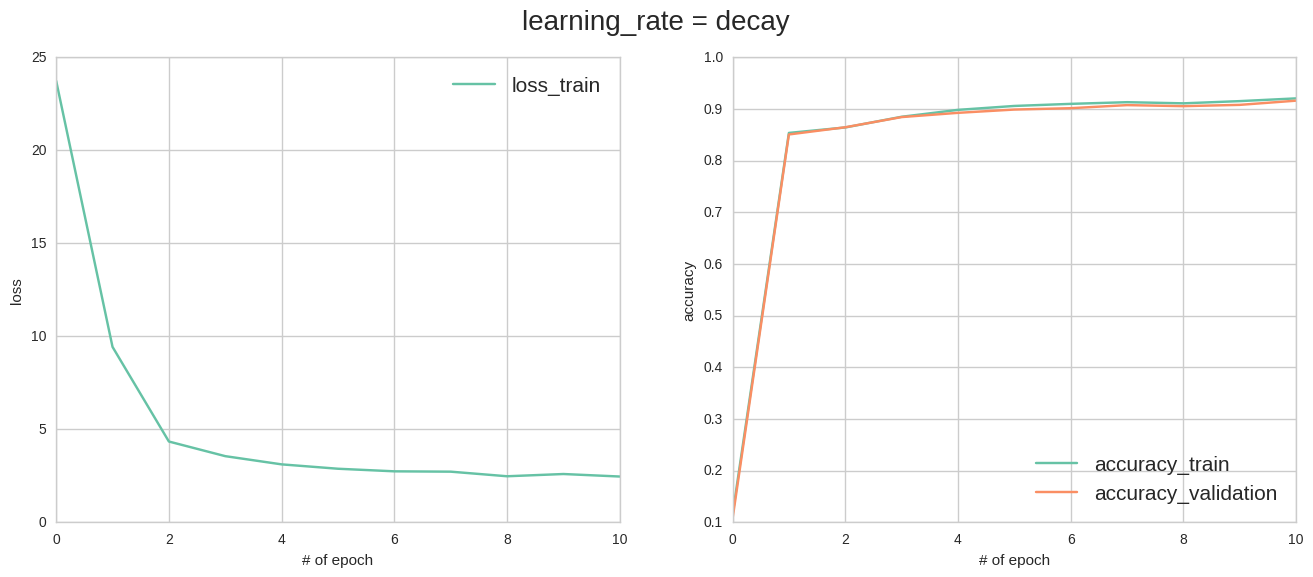

In [30]:
model2 = nn.Sequential()
model2.add(nn.Linear(784, 50), 'Linear1')
model2.add(nn.Sigmoid(50, 50))
model2.add(nn.Linear(50, 10), 'Linear2')
model2.add(nn.CrossEntropyCriterion())
evaluation_results = main(model2, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='decay', 
                          n_epoch=10)
plot_results(evaluation_results, 'learning_rate = decay')

Epoch: 0    Loss: 24.66816  Accuracy (train): 0.10007   Accuracy (val): 0.10743   
Epoch: 1    Loss: 8.04327   Accuracy (train): 0.85069   Accuracy (val): 0.84871   
Epoch: 2    Loss: 3.52325   Accuracy (train): 0.88233   Accuracy (val): 0.87743   
Epoch: 3    Loss: 2.73289   Accuracy (train): 0.90050   Accuracy (val): 0.89636   
Epoch: 4    Loss: 2.32309   Accuracy (train): 0.90767   Accuracy (val): 0.90314   
Epoch: 5    Loss: 2.41383   Accuracy (train): 0.89740   Accuracy (val): 0.89143   
Epoch: 6    Loss: 2.48220   Accuracy (train): 0.91955   Accuracy (val): 0.91364   
Epoch: 7    Loss: 2.44765   Accuracy (train): 0.92033   Accuracy (val): 0.91257   
Epoch: 8    Loss: 2.20046   Accuracy (train): 0.92050   Accuracy (val): 0.91500   
Epoch: 9    Loss: 2.33993   Accuracy (train): 0.92393   Accuracy (val): 0.91550   
Epoch: 10   Loss: 2.23803   Accuracy (train): 0.92764   Accuracy (val): 0.91750   
Final accuracy on test_set: 0.92464   


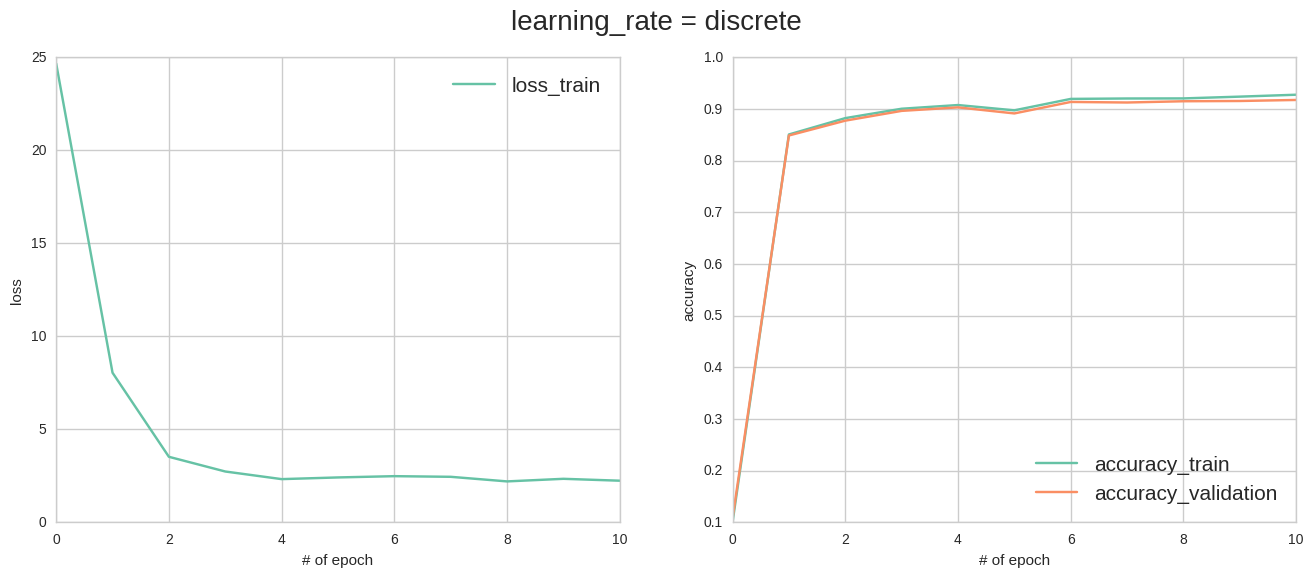

In [31]:
model2 = nn.Sequential()
model2.add(nn.Linear(784, 50), 'Linear1')
model2.add(nn.Sigmoid(50, 50))
model2.add(nn.Linear(50, 10), 'Linear2')
model2.add(nn.CrossEntropyCriterion())
evaluation_results = main(model2, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=10)
plot_results(evaluation_results, 'learning_rate = discrete')

### Оставим вариант с *learning_rate : discrete*, увеличим количество эпох до 50.

Epoch: 0    Loss: 24.11407  Accuracy (train): 0.08505   Accuracy (val): 0.08321   
Epoch: 1    Loss: 8.17292   Accuracy (train): 0.85155   Accuracy (val): 0.84786   
Epoch: 2    Loss: 3.44124   Accuracy (train): 0.87152   Accuracy (val): 0.86664   
Epoch: 3    Loss: 2.67399   Accuracy (train): 0.89479   Accuracy (val): 0.89129   
Epoch: 4    Loss: 2.35813   Accuracy (train): 0.90040   Accuracy (val): 0.89579   
Epoch: 5    Loss: 2.16063   Accuracy (train): 0.91590   Accuracy (val): 0.90936   
Epoch: 6    Loss: 1.98398   Accuracy (train): 0.91119   Accuracy (val): 0.90436   
Epoch: 7    Loss: 1.78274   Accuracy (train): 0.91610   Accuracy (val): 0.91157   
Epoch: 8    Loss: 1.82292   Accuracy (train): 0.92762   Accuracy (val): 0.92200   
Epoch: 9    Loss: 1.63063   Accuracy (train): 0.90838   Accuracy (val): 0.90150   
Epoch: 10   Loss: 1.59541   Accuracy (train): 0.90869   Accuracy (val): 0.90043   
Epoch: 11   Loss: 1.53160   Accuracy (train): 0.91364   Accuracy (val): 0.90707   
Epoc

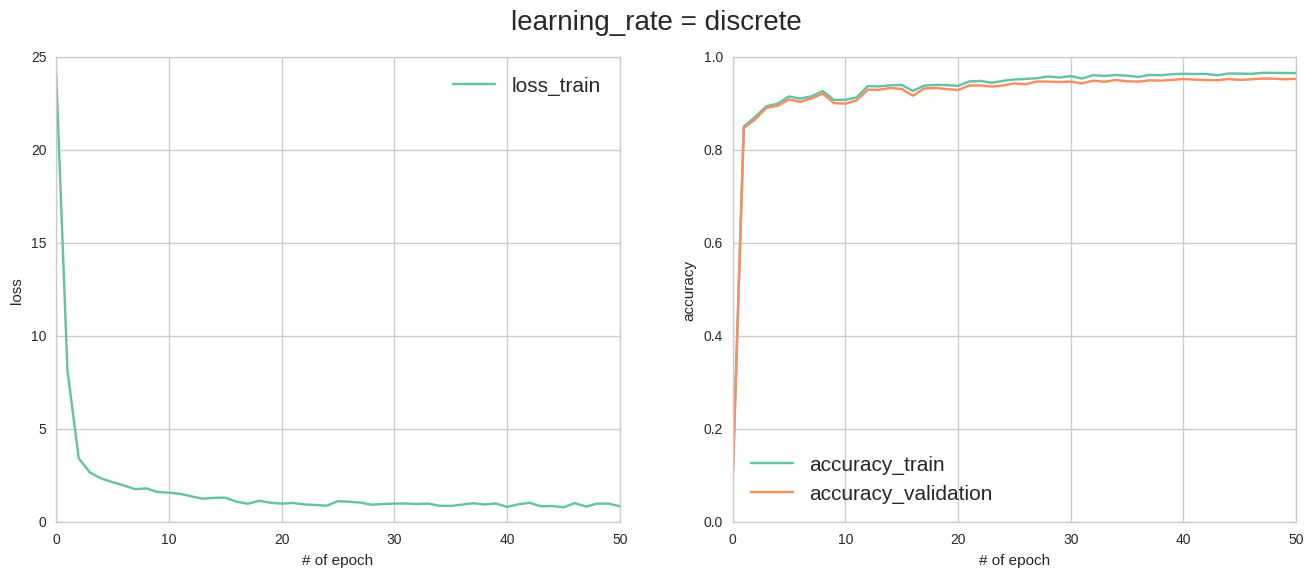

In [32]:
model2 = nn.Sequential()
model2.add(nn.Linear(784, 50), 'Linear1')
model2.add(nn.Sigmoid(50, 50))
model2.add(nn.Linear(50, 10), 'Linear2')
model2.add(nn.CrossEntropyCriterion())
evaluation_results = main(model2, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50)
plot_results(evaluation_results, 'learning_rate = discrete')

### Получаем точность на тесте *0.954*. Попробуем другие функции активации. Начнем с *Tanh*:

Epoch: 0    Loss: 23.61163  Accuracy (train): 0.11414   Accuracy (val): 0.11236   
Epoch: 1    Loss: 2.72332   Accuracy (train): 0.89726   Accuracy (val): 0.89150   
Epoch: 2    Loss: 1.37505   Accuracy (train): 0.90245   Accuracy (val): 0.89450   
Epoch: 3    Loss: 1.12481   Accuracy (train): 0.90255   Accuracy (val): 0.89793   
Epoch: 4    Loss: 0.87813   Accuracy (train): 0.91581   Accuracy (val): 0.90793   
Epoch: 5    Loss: 0.94173   Accuracy (train): 0.91943   Accuracy (val): 0.91436   
Epoch: 6    Loss: 0.87107   Accuracy (train): 0.91067   Accuracy (val): 0.90271   
Epoch: 7    Loss: 0.73407   Accuracy (train): 0.91590   Accuracy (val): 0.90707   
Epoch: 8    Loss: 0.62593   Accuracy (train): 0.92438   Accuracy (val): 0.91500   
Epoch: 9    Loss: 0.64812   Accuracy (train): 0.92964   Accuracy (val): 0.92029   
Epoch: 10   Loss: 0.56142   Accuracy (train): 0.91417   Accuracy (val): 0.90686   
Epoch: 11   Loss: 0.57707   Accuracy (train): 0.92188   Accuracy (val): 0.91514   
Epoc

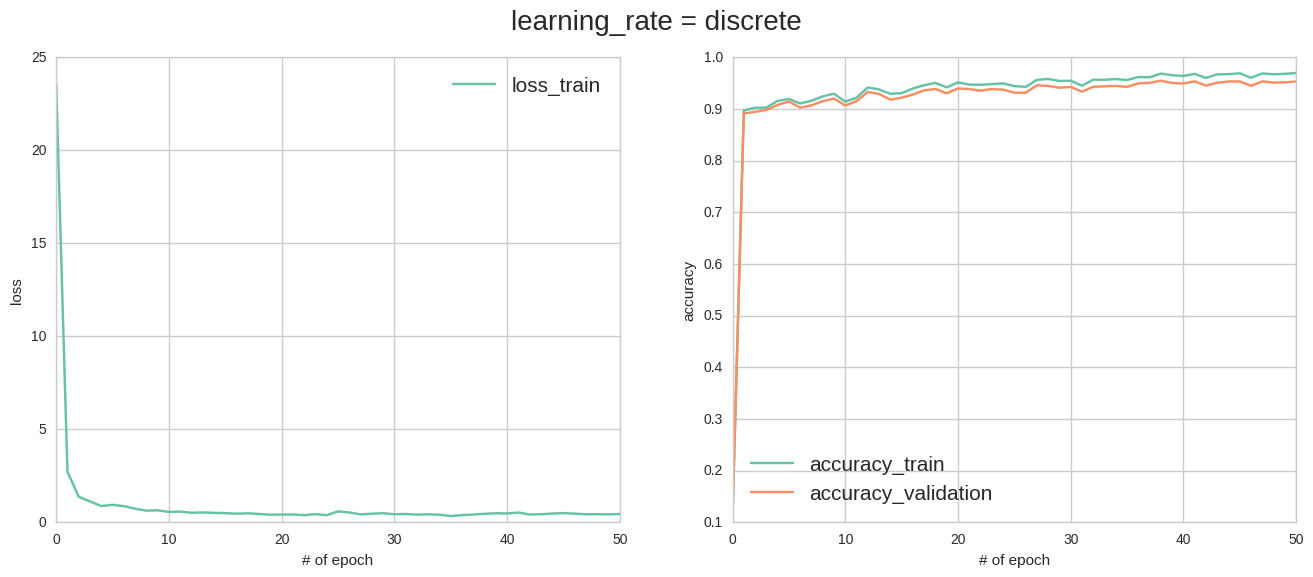

In [33]:
model2 = nn.Sequential()
model2.add(nn.Linear(784, 50), 'Linear1')
model2.add(nn.Tanh(50, 50))
model2.add(nn.Linear(50, 10), 'Linear2')
model2.add(nn.CrossEntropyCriterion())
evaluation_results = main(model2, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50)
plot_results(evaluation_results, 'learning_rate = discrete')

### С гипертангенсом те же *0.954* на тесте. Пробуем линейную активацию.

Epoch: 0    Loss: 25.35332  Accuracy (train): 0.09733   Accuracy (val): 0.09893   
Epoch: 1    Loss: 9.31238   Accuracy (train): 0.84317   Accuracy (val): 0.84643   
Epoch: 2    Loss: 4.16459   Accuracy (train): 0.87571   Accuracy (val): 0.87079   
Epoch: 3    Loss: 3.38806   Accuracy (train): 0.88140   Accuracy (val): 0.87550   
Epoch: 4    Loss: 3.08787   Accuracy (train): 0.89298   Accuracy (val): 0.88800   
Epoch: 5    Loss: 2.68807   Accuracy (train): 0.89131   Accuracy (val): 0.88507   
Epoch: 6    Loss: 2.62767   Accuracy (train): 0.89505   Accuracy (val): 0.88779   
Epoch: 7    Loss: 2.62334   Accuracy (train): 0.90093   Accuracy (val): 0.89336   
Epoch: 8    Loss: 2.45747   Accuracy (train): 0.90169   Accuracy (val): 0.89250   
Epoch: 9    Loss: 2.47315   Accuracy (train): 0.90476   Accuracy (val): 0.90100   
Epoch: 10   Loss: 2.44930   Accuracy (train): 0.90293   Accuracy (val): 0.89600   
Epoch: 11   Loss: 2.22771   Accuracy (train): 0.90605   Accuracy (val): 0.89829   
Epoc

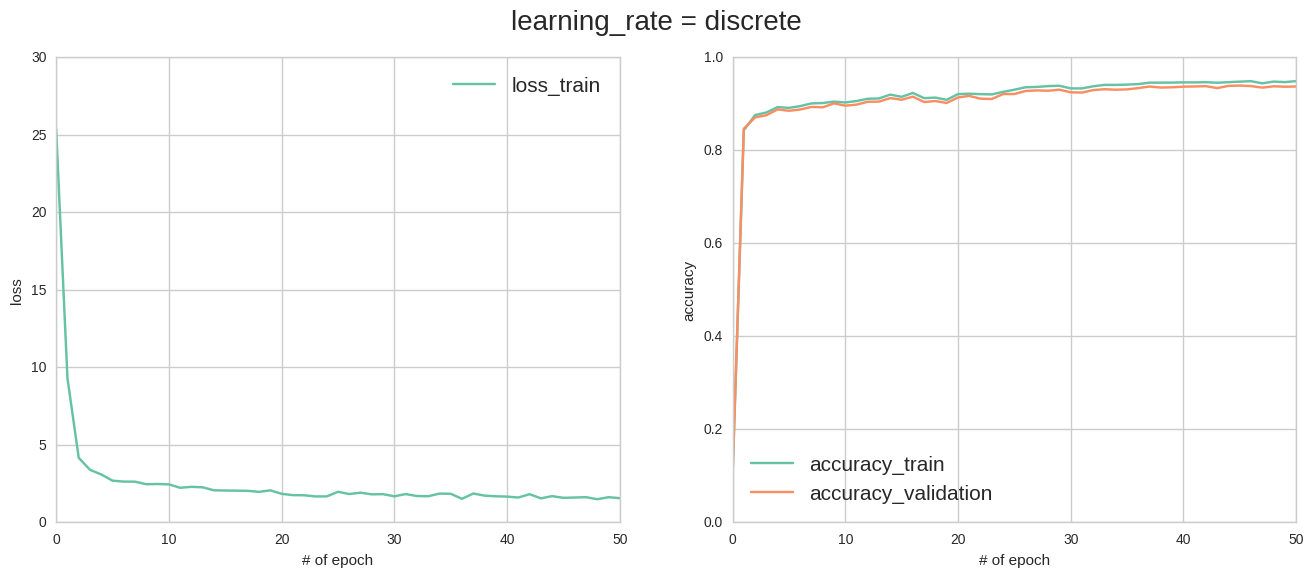

In [35]:
model2 = nn.Sequential()
model2.add(nn.Linear(784, 50), 'Linear1')
model2.add(nn.ReLU(50, 50))
model2.add(nn.Linear(50, 10), 'Linear2')
model2.add(nn.CrossEntropyCriterion())
evaluation_results = main(model2, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-4, learning_rate_evolution='discrete', 
                          n_epoch=50)
plot_results(evaluation_results, 'learning_rate = discrete')

### Для корректной работы с *ReLU*-активацией пришлось на порядок уменьшить *learning_rate*. Тем не менее, результат оказался всё равно хуже, чем с *Tanh*.

# 3. Попробуем поменять функцию потерь на квадратичную. 

### Логрегрессия c *Sigmoid*:

Epoch: 0    Loss: 0.00067   Accuracy (train): 0.06586   Accuracy (val): 0.06621   
Epoch: 1    Loss: 0.57305   Accuracy (train): 0.79502   Accuracy (val): 0.78621   
Epoch: 2    Loss: 0.34478   Accuracy (train): 0.84350   Accuracy (val): 0.83879   
Epoch: 3    Loss: 0.30995   Accuracy (train): 0.84840   Accuracy (val): 0.84350   
Epoch: 4    Loss: 0.27151   Accuracy (train): 0.87086   Accuracy (val): 0.86786   
Epoch: 5    Loss: 0.25180   Accuracy (train): 0.86488   Accuracy (val): 0.86050   
Epoch: 6    Loss: 0.25060   Accuracy (train): 0.87850   Accuracy (val): 0.87607   
Epoch: 7    Loss: 0.23865   Accuracy (train): 0.87962   Accuracy (val): 0.87829   
Epoch: 8    Loss: 0.22702   Accuracy (train): 0.88119   Accuracy (val): 0.87714   
Epoch: 9    Loss: 0.22443   Accuracy (train): 0.87957   Accuracy (val): 0.87550   
Epoch: 10   Loss: 0.22151   Accuracy (train): 0.88719   Accuracy (val): 0.88221   
Epoch: 11   Loss: 0.21649   Accuracy (train): 0.88269   Accuracy (val): 0.87936   
Epoc

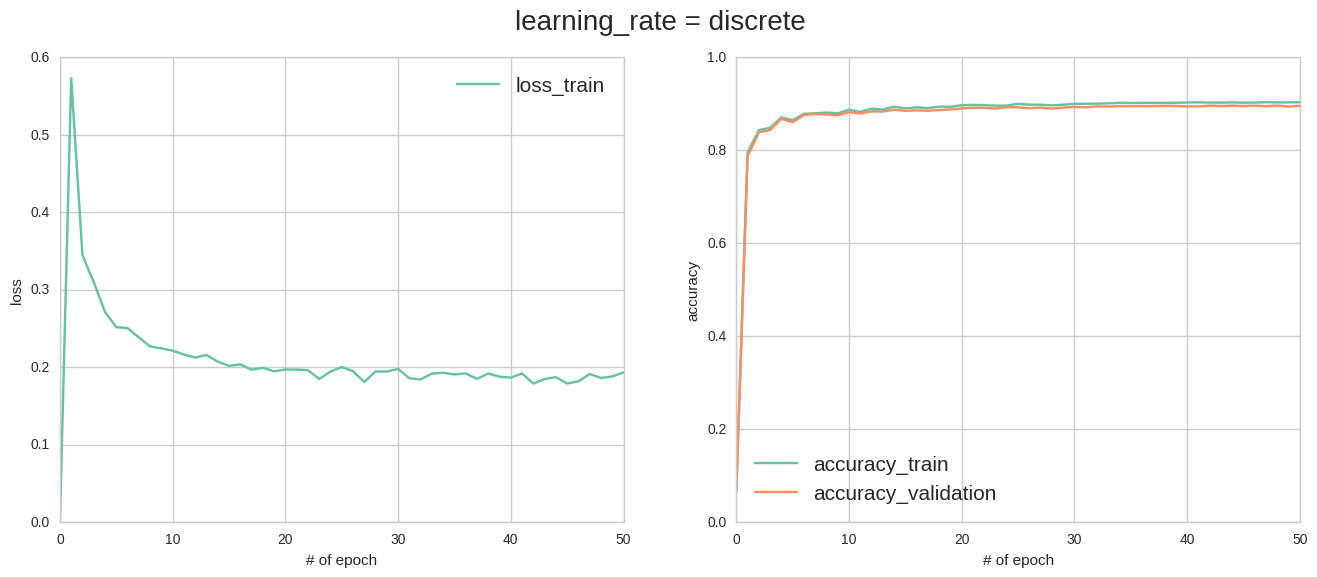

In [36]:
model3 = nn.Sequential()
model3.add(nn.Linear(784, 10))
model3.add(nn.Sigmoid(10, 10))
model3.add(nn.MSE())
evaluation_results = main(model3, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50)
plot_results(evaluation_results, 'learning_rate = discrete')

#### Получилось похуже, чем для кросс-энтропии.
### Логрегрессия c *Tanh*:

Epoch: 0    Loss: 0.00128   Accuracy (train): 0.15190   Accuracy (val): 0.14829   
Epoch: 1    Loss: 0.56215   Accuracy (train): 0.74443   Accuracy (val): 0.73500   
Epoch: 2    Loss: 0.42024   Accuracy (train): 0.77519   Accuracy (val): 0.77193   
Epoch: 3    Loss: 0.38571   Accuracy (train): 0.76621   Accuracy (val): 0.76543   
Epoch: 4    Loss: 0.37786   Accuracy (train): 0.79614   Accuracy (val): 0.79171   
Epoch: 5    Loss: 0.37215   Accuracy (train): 0.79933   Accuracy (val): 0.79186   
Epoch: 6    Loss: 0.36704   Accuracy (train): 0.79245   Accuracy (val): 0.78964   
Epoch: 7    Loss: 0.36160   Accuracy (train): 0.80581   Accuracy (val): 0.80229   
Epoch: 8    Loss: 0.36202   Accuracy (train): 0.81481   Accuracy (val): 0.80979   
Epoch: 9    Loss: 0.35725   Accuracy (train): 0.77824   Accuracy (val): 0.76721   
Epoch: 10   Loss: 0.35559   Accuracy (train): 0.79817   Accuracy (val): 0.78814   
Epoch: 11   Loss: 0.35377   Accuracy (train): 0.79598   Accuracy (val): 0.78750   
Epoc

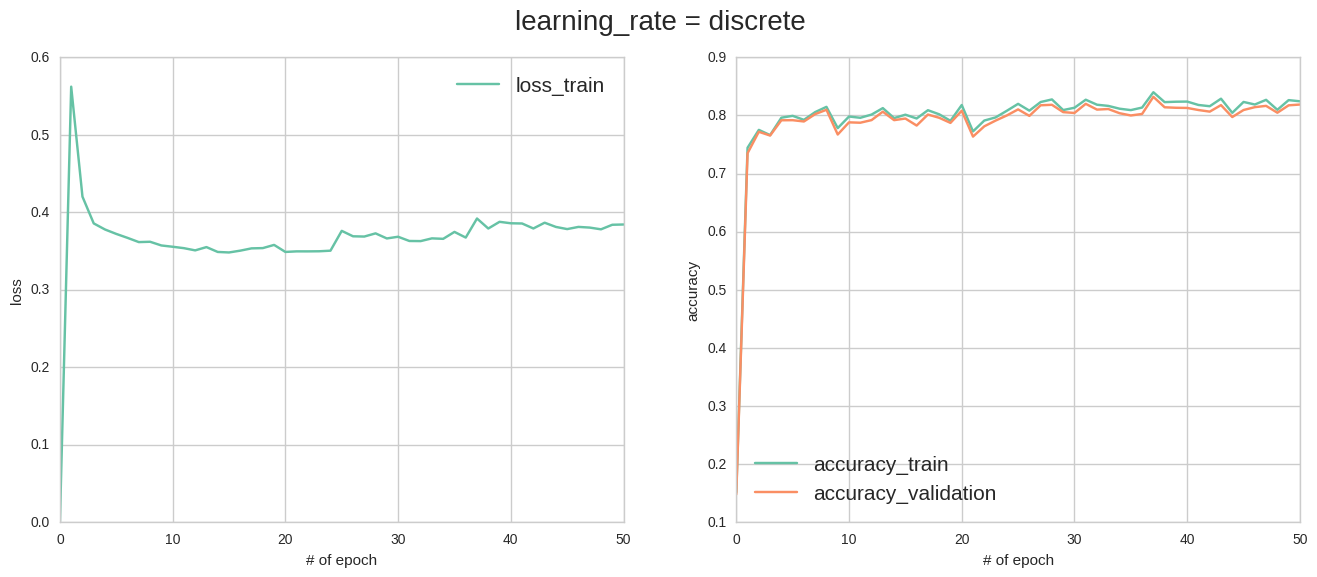

In [37]:
model3 = nn.Sequential()
model3.add(nn.Linear(784, 10))
model3.add(nn.Tanh(10, 10))
model3.add(nn.MSE())
evaluation_results = main(model3, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50)
plot_results(evaluation_results, 'learning_rate = discrete')

#### Это уже никуда не годится - всего лишь *0.823*.

### MLP c *Tanh*:

Epoch: 0    Loss: 0.00070   Accuracy (train): 0.06748   Accuracy (val): 0.07093   
Epoch: 1    Loss: 0.51693   Accuracy (train): 0.83157   Accuracy (val): 0.83229   
Epoch: 2    Loss: 0.36828   Accuracy (train): 0.85638   Accuracy (val): 0.85414   
Epoch: 3    Loss: 0.30534   Accuracy (train): 0.87640   Accuracy (val): 0.86971   
Epoch: 4    Loss: 0.26905   Accuracy (train): 0.87855   Accuracy (val): 0.87079   
Epoch: 5    Loss: 0.23827   Accuracy (train): 0.89398   Accuracy (val): 0.88979   
Epoch: 6    Loss: 0.22032   Accuracy (train): 0.89779   Accuracy (val): 0.89521   
Epoch: 7    Loss: 0.20736   Accuracy (train): 0.89879   Accuracy (val): 0.89357   
Epoch: 8    Loss: 0.19202   Accuracy (train): 0.90624   Accuracy (val): 0.89864   
Epoch: 9    Loss: 0.18857   Accuracy (train): 0.90448   Accuracy (val): 0.90029   
Epoch: 10   Loss: 0.17770   Accuracy (train): 0.89833   Accuracy (val): 0.89029   
Epoch: 11   Loss: 0.16792   Accuracy (train): 0.90988   Accuracy (val): 0.90386   
Epoc

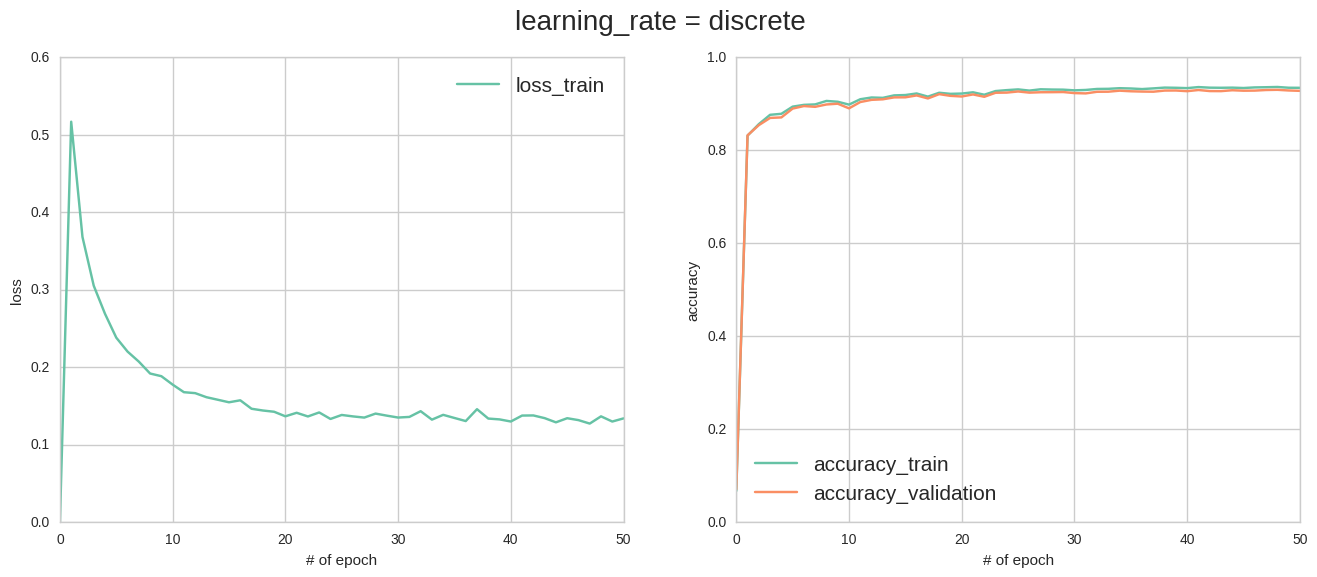

In [38]:
model4 = nn.Sequential()
model4.add(nn.Linear(784, 50), 'Linear1')
model4.add(nn.Tanh(50, 50), 'Tanh1')
model4.add(nn.Linear(50, 10), 'Linear2')
model4.add(nn.Tanh(10, 10), 'Tanh2')
model4.add(nn.MSE())
evaluation_results = main(model4, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50)
plot_results(evaluation_results, 'learning_rate = discrete')

### Похоже, что *MSE* проигрывает *Cross-Entropy* в данной задаче.

# 4. Попробуем добавить *L2*-регуляризацию в модель с самым лучшим результатом.

### Начнем с параметра $\lambda$= *1е-5*:

Epoch: 0    Loss: 25.10124  Accuracy (train): 0.07269   Accuracy (val): 0.07321   
Epoch: 1    Loss: 3.00653   Accuracy (train): 0.87786   Accuracy (val): 0.87314   
Epoch: 2    Loss: 1.38947   Accuracy (train): 0.86812   Accuracy (val): 0.86243   
Epoch: 3    Loss: 1.10142   Accuracy (train): 0.86198   Accuracy (val): 0.86093   
Epoch: 4    Loss: 0.94120   Accuracy (train): 0.88126   Accuracy (val): 0.87243   
Epoch: 5    Loss: 0.80909   Accuracy (train): 0.89948   Accuracy (val): 0.89121   
Epoch: 6    Loss: 0.80988   Accuracy (train): 0.89062   Accuracy (val): 0.88221   
Epoch: 7    Loss: 0.85487   Accuracy (train): 0.90545   Accuracy (val): 0.89500   
Epoch: 8    Loss: 0.69306   Accuracy (train): 0.92133   Accuracy (val): 0.91079   
Epoch: 9    Loss: 0.65895   Accuracy (train): 0.92629   Accuracy (val): 0.91314   
Epoch: 10   Loss: 0.62709   Accuracy (train): 0.91729   Accuracy (val): 0.91186   
Epoch: 11   Loss: 0.67154   Accuracy (train): 0.92031   Accuracy (val): 0.91043   
Epoc

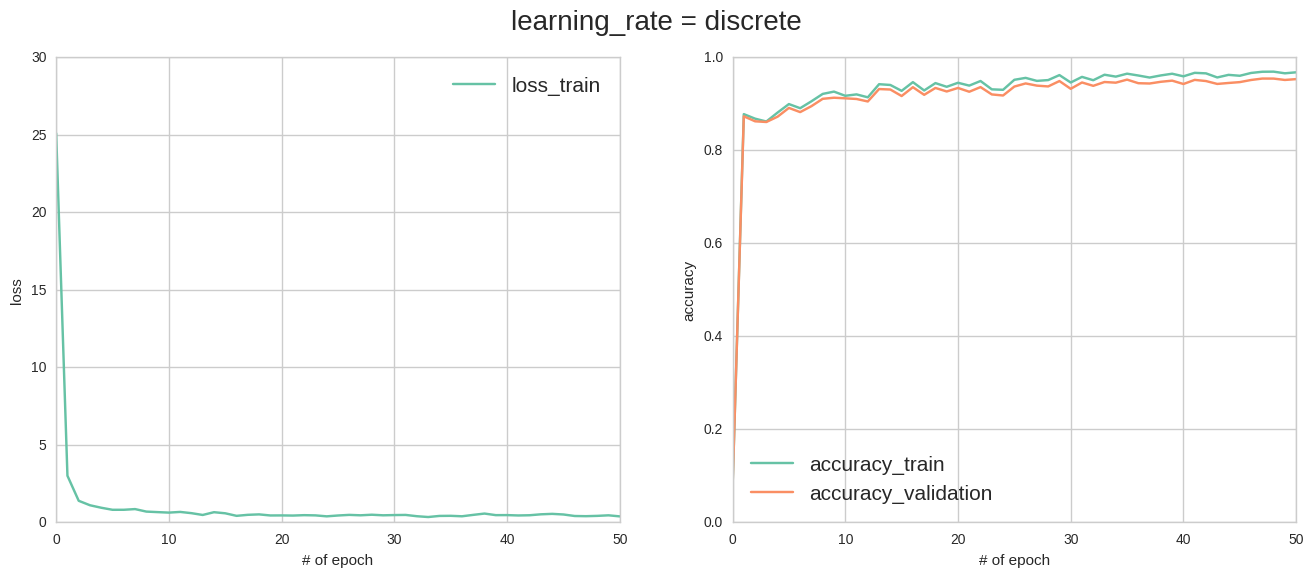

In [39]:
model5 = nn.Sequential()
model5.add(nn.Linear(784, 50), 'Linear1')
model5.add(nn.Tanh(50, 50))
model5.add(nn.Linear(50, 10), 'Linear2')
model5.add(nn.CrossEntropyCriterion())
evaluation_results = main(model5, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50, lambda_reg = 1e-5)
plot_results(evaluation_results, 'learning_rate = discrete')

### Получилось чуть похуже, чем в прошлый раз (было *0.954*). Попробуем увеличить на пол-порядка $\lambda$:

Epoch: 0    Loss: 25.27890  Accuracy (train): 0.08376   Accuracy (val): 0.08393   
Epoch: 1    Loss: 2.82549   Accuracy (train): 0.86564   Accuracy (val): 0.86171   
Epoch: 2    Loss: 1.37248   Accuracy (train): 0.89419   Accuracy (val): 0.89014   
Epoch: 3    Loss: 1.10215   Accuracy (train): 0.87029   Accuracy (val): 0.86186   
Epoch: 4    Loss: 0.99447   Accuracy (train): 0.91086   Accuracy (val): 0.90471   
Epoch: 5    Loss: 0.85316   Accuracy (train): 0.90881   Accuracy (val): 0.90343   
Epoch: 6    Loss: 0.83488   Accuracy (train): 0.91452   Accuracy (val): 0.91000   
Epoch: 7    Loss: 0.77060   Accuracy (train): 0.92479   Accuracy (val): 0.91550   
Epoch: 8    Loss: 0.69312   Accuracy (train): 0.90933   Accuracy (val): 0.90350   
Epoch: 9    Loss: 0.72902   Accuracy (train): 0.93707   Accuracy (val): 0.92986   
Epoch: 10   Loss: 0.62388   Accuracy (train): 0.92864   Accuracy (val): 0.92114   
Epoch: 11   Loss: 0.61025   Accuracy (train): 0.93136   Accuracy (val): 0.92471   
Epoc

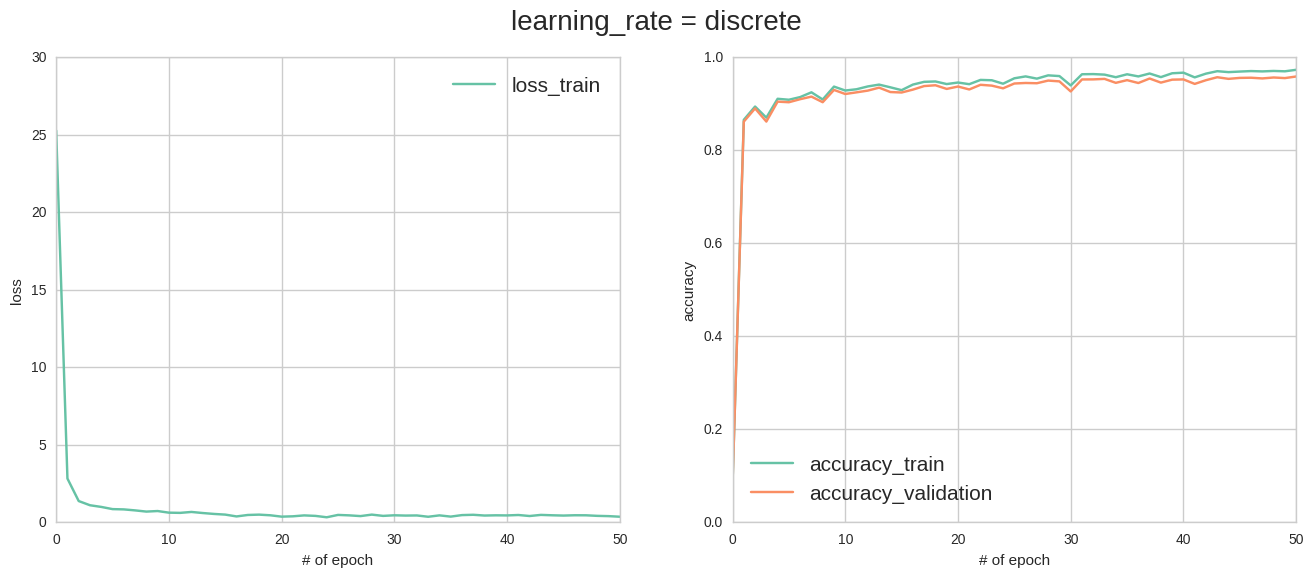

In [41]:
model5 = nn.Sequential()
model5.add(nn.Linear(784, 50), 'Linear1')
model5.add(nn.Tanh(50, 50))
model5.add(nn.Linear(50, 10), 'Linear2')
model5.add(nn.CrossEntropyCriterion())
evaluation_results = main(model5, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50, lambda_reg = 5 * 1e-5)
plot_results(evaluation_results, 'learning_rate = discrete')

### Вот теперь получили небольшой прирост на *0.001*. Попробуем еще:

Epoch: 0    Loss: 25.43621  Accuracy (train): 0.08855   Accuracy (val): 0.09014   
Epoch: 1    Loss: 2.87886   Accuracy (train): 0.88262   Accuracy (val): 0.87507   
Epoch: 2    Loss: 1.34120   Accuracy (train): 0.89495   Accuracy (val): 0.89121   
Epoch: 3    Loss: 1.11548   Accuracy (train): 0.90733   Accuracy (val): 0.89829   
Epoch: 4    Loss: 0.98454   Accuracy (train): 0.90788   Accuracy (val): 0.89936   
Epoch: 5    Loss: 0.96182   Accuracy (train): 0.91921   Accuracy (val): 0.91236   
Epoch: 6    Loss: 0.82582   Accuracy (train): 0.93057   Accuracy (val): 0.92521   
Epoch: 7    Loss: 0.82915   Accuracy (train): 0.91683   Accuracy (val): 0.90657   
Epoch: 8    Loss: 0.68946   Accuracy (train): 0.92969   Accuracy (val): 0.92443   
Epoch: 9    Loss: 0.63095   Accuracy (train): 0.92093   Accuracy (val): 0.91371   
Epoch: 10   Loss: 0.57879   Accuracy (train): 0.93633   Accuracy (val): 0.92979   
Epoch: 11   Loss: 0.58118   Accuracy (train): 0.93895   Accuracy (val): 0.93186   
Epoc

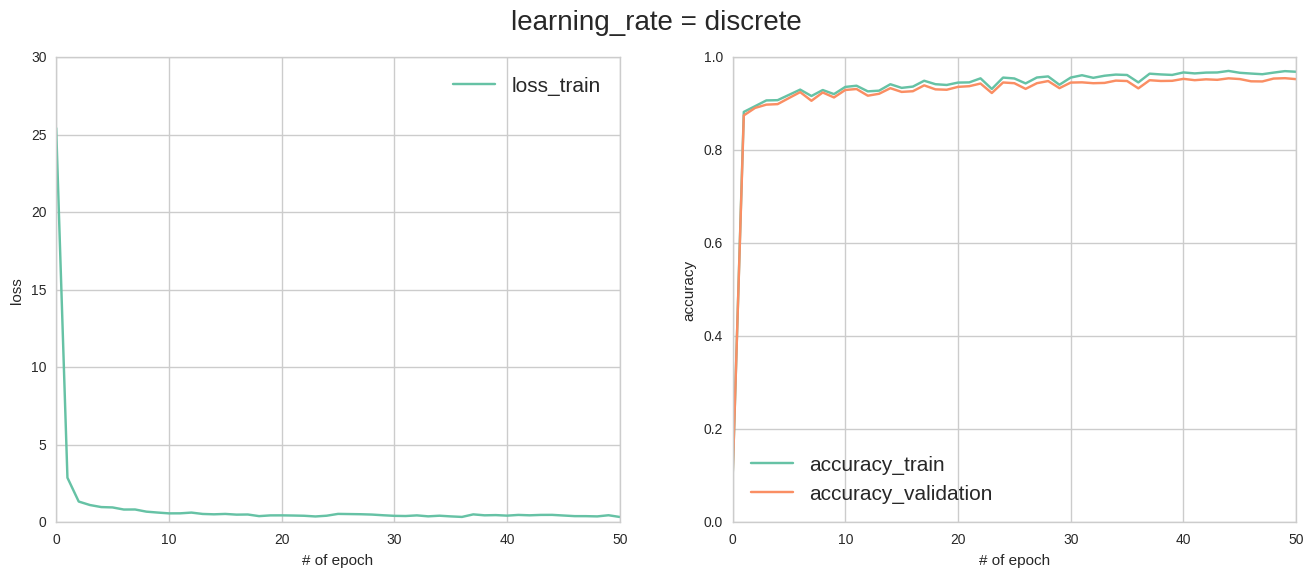

In [42]:
model5 = nn.Sequential()
model5.add(nn.Linear(784, 50), 'Linear1')
model5.add(nn.Tanh(50, 50))
model5.add(nn.Linear(50, 10), 'Linear2')
model5.add(nn.CrossEntropyCriterion())
evaluation_results = main(model5, X_train, y_train, X_test, y_test, X_val, y_val, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=50, lambda_reg = 1e-4)
plot_results(evaluation_results, 'learning_rate = discrete')

### Стало быть, лучший результат, который мы получили: *0.957*. 

In [44]:
print ('Cheerio!')

Cheerio!


Epoch: 0    Loss: 31.66805  Accuracy (train): 0.11027   Accuracy (test): 0.10607   
Epoch: 1    Loss: 2.94216   Accuracy (train): 0.85845   Accuracy (test): 0.85629   
Epoch: 2    Loss: 1.37650   Accuracy (train): 0.86013   Accuracy (test): 0.85900   
Epoch: 3    Loss: 1.25289   Accuracy (train): 0.88173   Accuracy (test): 0.88157   
Epoch: 4    Loss: 1.17445   Accuracy (train): 0.91254   Accuracy (test): 0.91229   
Epoch: 5    Loss: 0.96518   Accuracy (train): 0.90609   Accuracy (test): 0.90693   
Epoch: 6    Loss: 0.88174   Accuracy (train): 0.91604   Accuracy (test): 0.90957   
Epoch: 7    Loss: 0.92070   Accuracy (train): 0.90468   Accuracy (test): 0.90264   
Epoch: 8    Loss: 0.75608   Accuracy (train): 0.91466   Accuracy (test): 0.91057   
Epoch: 9    Loss: 0.78241   Accuracy (train): 0.91857   Accuracy (test): 0.91707   
Epoch: 10   Loss: 0.61326   Accuracy (train): 0.92405   Accuracy (test): 0.91871   
Epoch: 11   Loss: 0.56108   Accuracy (train): 0.93312   Accuracy (test): 0.9

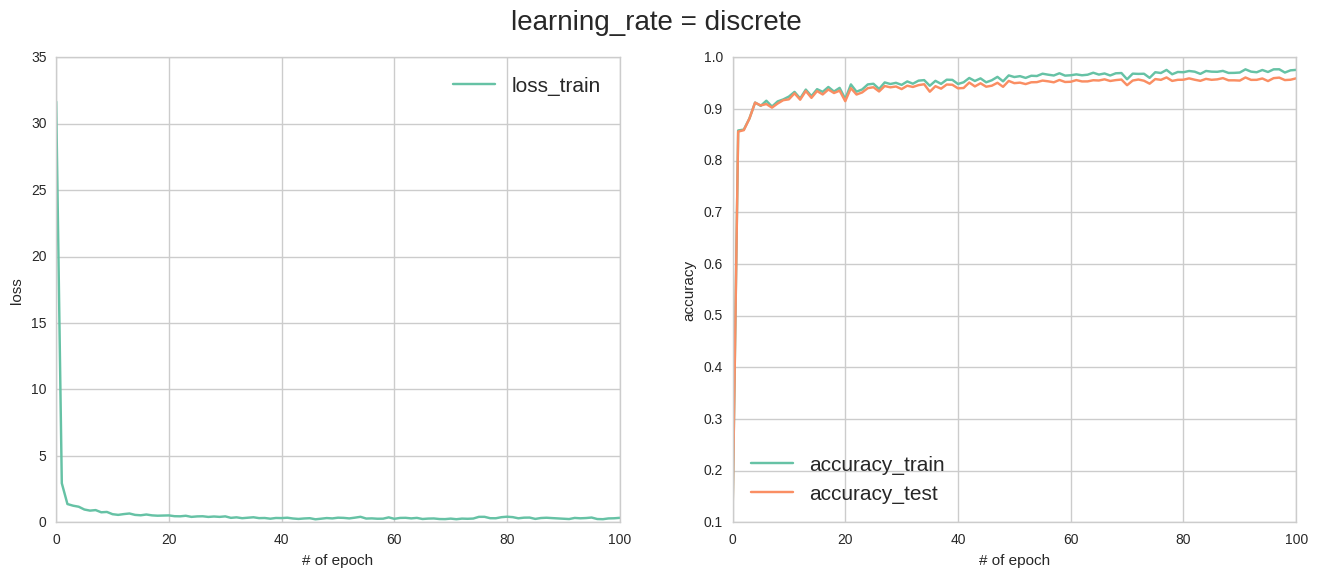

In [20]:
model5 = nn.Sequential()
model5.add(nn.Linear(784, 50), 'Linear1')
model5.add(nn.Tanh(50, 50))
model5.add(nn.Linear(50, 10), 'Linear2')
model5.add(nn.CrossEntropyCriterion())
evaluation_results = main(model5, X_train, y_train, X_test, y_test, 
                          learning_rate=1e-3, learning_rate_evolution='discrete', 
                          n_epoch=100, lambda_reg = 5 * 1e-5)
plot_results(evaluation_results, 'learning_rate = discrete')